In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j



Note: for final project for deep learning course I will construct a simpler non-probabilistic version of JEPPS. For final project of supervised learning I will do a ML instead of DL version of JEPPS

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2025-10-17 08:31:50.990815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760689911.245806      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760689911.312084      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.18.0


In [3]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMAGESIZE = (256, 256)
BATCH_SIZE = 32
NOISE_DIM = 100
EPOCHS = 50
CHANNELS = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.resize(image, IMAGESIZE)
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
       
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    return image

def load_dataset(file_names):
    dataset = tf.data.TFRecordDataset(file_names)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(2048).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

In [6]:
path_monet = "/kaggle/input/gan-getting-started/monet_jpg"


In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Latent space: noise_dim=100
    model.add(layers.Dense(16*16*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16, 16, 512)))    # 16x16x512

    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())               # 32x32x256

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())               # 64x64x128

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())               # 128x128x64

    model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())               # 256x256x32

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', use_bias=False, activation='tanh')) # 256x256x3
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-17 08:32:12.668571: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


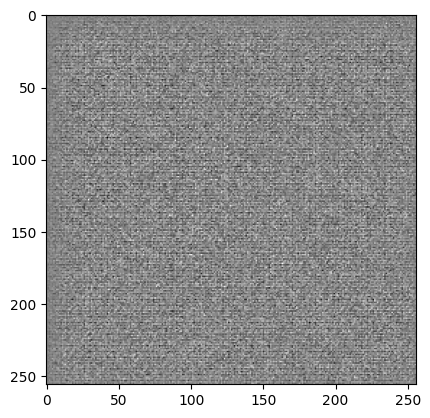

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(256, 256, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[6.542646e-05]], shape=(1, 1), dtype=float32)


In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
generator_optimizer = tf.keras.optimizers.Lion()
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)# the discriminator is simply doing real or fake binary classification

In [14]:
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def generate_and_save_images(model, epoch, seed, n=4):
    predictions = model(seed, training=False)
    predictions = ((predictions + 1) * 127.5).numpy().astype(np.uint8)
    plt.figure(figsize=(n, n))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

In [17]:
import time
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    #print(f"Epoch {epoch+1}/{epochs} - Gen Loss: {g_loss_accum/batch_count:.4f}, Disc Loss: {d_loss_accum/batch_count:.4f}, Time: {time.time()-start:.2f}s")

    # Produce images for the GIF as you go
    clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  clear_output(wait=True)

  generate_and_save_images(generator,
                           epochs,
                           seed)

In [18]:
import tensorflow as tf
import os

IMAGESIZE = (256, 256)
BATCH_SIZE = 32

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGESIZE)
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5  # for tanh
    return image

def make_dataset(folder):
    files = [os.path.join(folder, fname) for fname in os.listdir(folder) if fname.lower().endswith('.jpg')]
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=2048).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

monet_ds = make_dataset('/kaggle/input/gan-getting-started/monet_jpg')



In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
g_loss_accum = 0.0
d_loss_accum = 0.0
batch_count = 0


In [22]:
import tensorflow as tf
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


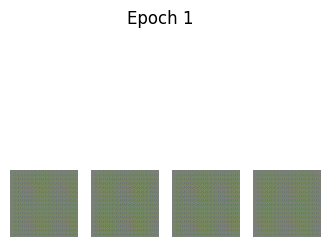

In [23]:
train(monet_ds, EPOCHS)

In [24]:
import os
import numpy as np
from PIL import Image

result_dir = "./images/"
os.makedirs(result_dir, exist_ok=True)

noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
generated_images = generator(noise, training=False)

# Proper denormalization: move from [-1, 1] to [0, 255] BEFORE converting to uint8!
generated_images = ((generated_images + 1) * 127.5).numpy()
generated_images = np.clip(generated_images, 0, 255).astype(np.uint8)  # Extra safety

for i in range(generated_images.shape[0]):
    img = Image.fromarray(generated_images[i])
    img.save(os.path.join(result_dir, f"image_{i:04d}.jpg"))

import shutil
shutil.make_archive('/kaggle/working/images', 'zip', result_dir)
 
#img.save(os.path.join(result_dir, f"image_{i:04d}.jpg"))

#import shutil
#shutil.make_archive('/kaggle/working/images', 'zip', result_dir)

'/kaggle/working/images.zip'

In [25]:
# predictions = model(test_input, training=False)

# fig = plt.figure(figsize=(4, 4))

# for i in range(predictions.shape[0]):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#     plt.axis('off')

In [26]:
# import PIL
# i = 1
# for img in photo_ds:
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [27]:
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

EDA (expoloratory data analysis that looks at: distribution of colors in the dataset and how the distribution of colors among the works of monet compared to the distribution of the images the generator produced 

In /kaggle/input/gan-getting-started/monet_jpg, found 300 image files.
Example file names: ['/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg', '/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg', '/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg', '/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg', '/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg']
In /kaggle/working/images, found 32 image files.
Example file names: ['/kaggle/working/images/image_0000.jpg', '/kaggle/working/images/image_0004.jpg', '/kaggle/working/images/image_0026.jpg', '/kaggle/working/images/image_0028.jpg', '/kaggle/working/images/image_0014.jpg']
Real colors array shape: (19660800, 3)
Generated colors array shape: (2097152, 3)


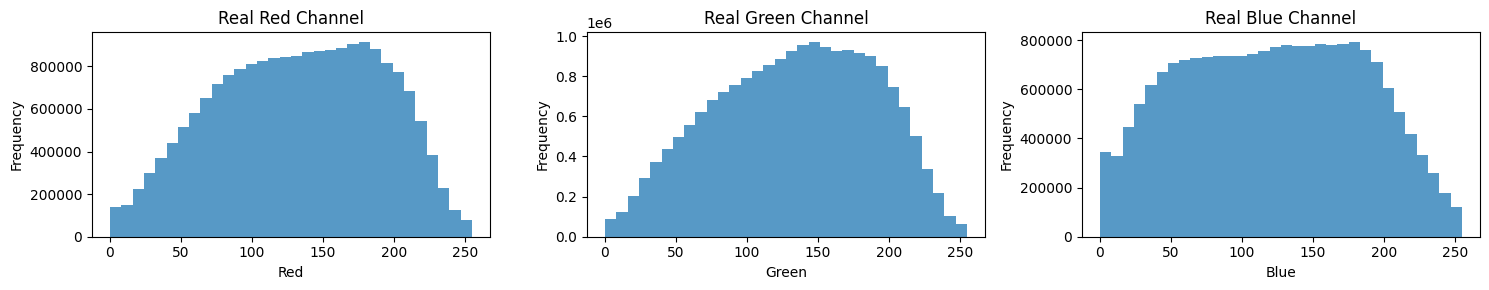

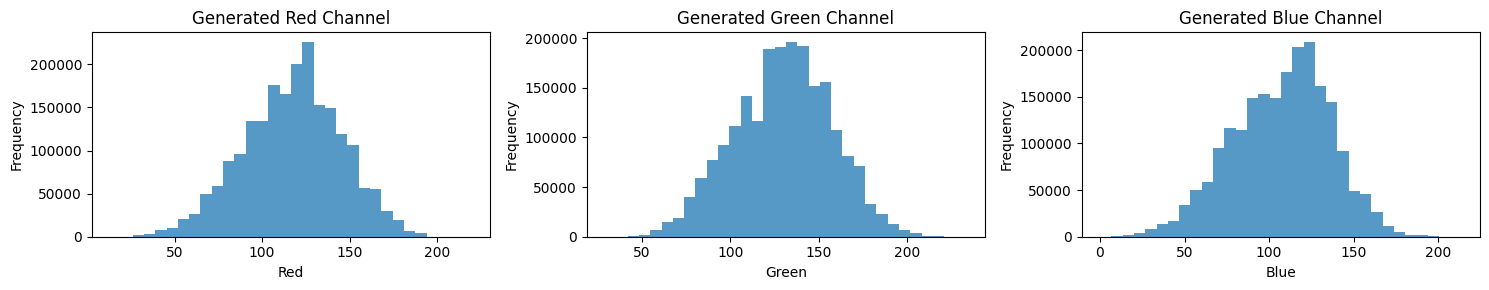

,color,real_count,gen_count
10,"(255, 255, 255)",15297,0
8,"(246, 246, 246)",3718,0
13,"(0, 2, 0)",1719,0
0,"(0, 1, 0)",1418,0
2,"(0, 3, 0)",1355,0
15,"(0, 4, 0)",1203,0
19,"(1, 0, 5)",1126,0
4,"(0, 0, 4)",997,0
1,"(255, 255, 253)",954,0
7,"(0, 5, 0)",943,0


In [28]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Real Monet images
real_dir = "/kaggle/input/gan-getting-started/monet_jpg"
# Generated images
gen_dir = "/kaggle/working/images"

def get_image_files(folder):
    files = [os.path.join(folder, fname) for fname in os.listdir(folder) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"In {folder}, found {len(files)} image files.")
    print("Example file names:", files[:5])
    return files

real_imgs = get_image_files(real_dir)
gen_imgs = get_image_files(gen_dir)

def flatten_colors(image_files):
    rgb_vals = []
    for img_file in image_files:
        try:
            img = Image.open(img_file).convert('RGB').resize((256,256))
            arr = np.array(img)
            arr = arr.reshape(-1, 3)
            rgb_vals.append(arr)
        except Exception as e:
            print(f"Error with {img_file}: {e}")
    if rgb_vals:
        return np.vstack(rgb_vals)
    else:
        return np.array([])

real_colors = flatten_colors(real_imgs)
gen_colors = flatten_colors(gen_imgs)

print(f"Real colors array shape: {real_colors.shape}")
print(f"Generated colors array shape: {gen_colors.shape}")

# 1. Color channel histograms
for (data, label) in [(real_colors, 'Real'), (gen_colors, 'Generated')]:
    if data.size > 0:
        plt.figure(figsize=(15,3))
        for i, col in enumerate(['Red','Green','Blue']):
            plt.subplot(1,3,i+1)
            plt.hist(data[:,i], bins=32, alpha=0.75)
            plt.title(f'{label} {col} Channel')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

# 2. Top 10 colors per set and combined color comparison
def get_top_colors(arr, k=10):
    arr_tuples = [tuple(color) for color in arr]
    top = Counter(arr_tuples).most_common(k)
    return top

real_top = get_top_colors(real_colors)
gen_top = get_top_colors(gen_colors)

# Union of top-10 colors in either set
all_unique_tops = list(set([c for c, _ in real_top] + [c for c, _ in gen_top]))

real_counter = Counter([tuple(c) for c in real_colors])
gen_counter = Counter([tuple(c) for c in gen_colors])

data = []
for color in all_unique_tops:
    data.append({'color': str(color),
                 'real_count': real_counter.get(color, 0),
                 'gen_count': gen_counter.get(color, 0)})

hist_df = pd.DataFrame(data)
display(hist_df.sort_values('real_count', ascending=False))






In [ ]:
import os
import numpy as np
from PIL import Image
import shutil
import math

result_dir = "./images"
os.makedirs(result_dir, exist_ok=True)

TOTAL_IMAGES = 8000  # Change to a number >= 7000 and <= 10000 to fit rules
BATCH_SIZE = 32

num_batches = math.ceil(TOTAL_IMAGES / BATCH_SIZE)
NOISE_DIM = 100  # Or whatever you use

img_num = 0
for batch in range(num_batches):
    batch_size = min(BATCH_SIZE, TOTAL_IMAGES - img_num)
    noise = tf.random.normal([batch_size, NOISE_DIM])
    generated_images = generator(noise, training=False)
    generated_images = ((generated_images + 1) * 127.5).numpy().astype(np.uint8)

    for i in range(batch_size):
        img = Image.fromarray(generated_images[i])
        img.save(os.path.join(result_dir, f"{img_num:05d}.jpg"))  # Zero-padded
        img_num += 1

shutil.make_archive("/kaggle/working/images", "zip", result_dir)



In [ ]:
# import os

# gen_dir = '/kaggle/working'  # or the specific subfolder if you used one

# files = os.listdir(gen_dir)
# imagefiles = [f for f in files if f.lower().endswith(('.jpg','.jpeg','.png'))]

# print("All files in generated dir:", files[:10])
# print("Image files in generated dir:", imagefiles[:10])
# print("Total found:", len(imagefiles))
